In [1]:
# https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#create-agent-supervisor

from dotenv import load_dotenv

from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

load_dotenv()

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

################################ Create Agent Supervisor

from typing import Literal
from typing_extensions import TypedDict

from langchain_ollama import ChatOllama

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*options]
    # next: Literal["researcher", "coder", "FINISH"]

# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
# llm = ChatOllama(model="mistral-small:latest", temperature=0, base_url = "http://192.168.1.203:11434")
llm = ChatOllama(model="qwq:latest", temperature=0, base_url = "http://192.168.1.203:11434")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})


################################ Construct Graph

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent   

research_prompt = "You are a researcher. DO NOT do any math."
research_agent = create_react_agent(
# research_agent = create_structured_chat_agent(
    llm, tools=[tavily_tool], prompt=research_prompt
)
# research_executor = AgentExecutor(agent=research_agent, tools=[tavily_tool])

def research_node(state: State) -> Command[Literal["supervisor"]]:
    # last_message = next((m for m in reversed(state["messages"]) if m["role"] == "user"), None)
    result = research_agent.invoke(state)
    # result = research_agent.invoke({"input": last_message["content"]})
    # result = research_executor.invoke({"input": last_message["content"]})
    # output = result.get("output", "No research results found.")
    return Command(
        update={
            "messages": [HumanMessage(content=result["messages"][-1].content, name="researcher")]
            # "messages": state["messages"] + [{"role": "assistant", "content": output, "name": "researcher"}]
        },
        goto="supervisor",
    )

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])
# code_agent = create_react_agent(llm, tools=[python_repl_tool], prompt=original_prompt)
# code_agent = create_structured_chat_agent(llm, [python_repl_tool], "You are a Python coder.")
# code_executor = AgentExecutor(agent=code_agent, tools=[python_repl_tool])

def code_node(state: State) -> Command[Literal["supervisor"]]:
    # last_message = next((m for m in reversed(state["messages"]) if m["role"] == "user"), None)
    result = code_agent.invoke(state)
    # result = code_agent.invoke({"input": last_message["content"]})
    # last_message = next((m for m in reversed(state["messages"]) if m["role"] == "user"), None)
    # result = code_executor.invoke({"input": last_message["content"]})
    # output = result.get("output", "No code results")
    return Command(
        update={
            "messages": [HumanMessage(content=result["messages"][-1].content, name="coder")]
            # "messages": state["messages"] + [{"role": "assistant", "content": output, "name": "coder"}]
        },
        goto="supervisor",
    )

builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

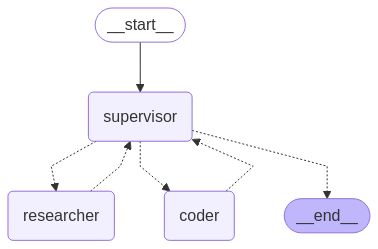

In [2]:
from IPython.display import display, Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print("Unable to display graph visualization")

In [4]:
# user_message = {"role": "user", "content": "What's the square root of 42?"}
# for s in graph.stream({"messages": [user_message]}, subgraphs=True):
#     print(s)
#     print("----")

for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")    

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:0dcc32b3-ea8f-63c4-1cc1-e66644c9eb8f',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwq:latest', 'created_at': '2025-04-28T06:24:33.806623224Z', 'done': True, 'done_reason': 'stop', 'total_duration': 13975968408, 'load_duration': 40050781, 'prompt_eval_count': 196, 'prompt_eval_duration': 140000000, 'eval_count': 348, 'eval_duration': 13773000000, 'model_name': 'qwq:latest'}, id='run-e96acc93-f73a-42c5-bd31-e315b9e5090a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest GDP of New York and California'}, 'id': 'c0199480-981a-4ea7-bd17-1efd0d8f0270', 'type': 'tool_call'}], usage_metadata={'input_tokens': 196, 'output_tokens': 348, 'total_tokens': 544})]}})
----
(('researcher:0dcc32b3-ea8f-63c4-1cc1-e66644c9eb8f',), {'tools': {'messages': [ToolMessage(content='[{"url": "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_GDP",

Python REPL can execute arbitrary code. Use with caution.


(('coder:3717c929-6219-48cc-ff31-4b66ab7ac9f7',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwq:latest', 'created_at': '2025-04-28T06:25:42.112417376Z', 'done': True, 'done_reason': 'stop', 'total_duration': 25537161320, 'load_duration': 38263380, 'prompt_eval_count': 1068, 'prompt_eval_duration': 1075000000, 'eval_count': 600, 'eval_duration': 24388000000, 'model_name': 'qwq:latest'}, id='run-45443cff-0e55-48c5-878f-f6bc6559674a-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'print((4.080 + 2.284)/2)'}, 'id': 'a5e05247-4a5b-4059-abb9-7430912b1cbb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1068, 'output_tokens': 600, 'total_tokens': 1668})]}})
----
(('coder:3717c929-6219-48cc-ff31-4b66ab7ac9f7',), {'tools': {'messages': [ToolMessage(content='Successfully executed:\n```python\nprint((4.080 + 2.284)/2)\n```\nStdout: 3.182\n', name='python_repl_tool', id='75f8c471-b90c-4b6c-80de-47211647a6d1', tool_call_id